# DataFlow

## Introduction

### Purpose

DataFlow is a framework designed to
- facilitate rapid and flexible prototyping
- deploy pipelines from research to production without software re-writes
- make complex data transformations understandable, repeatable, and debuggable

Though beyond the scope of this cookbook, we note that DataFlow
- can simulate the entire flow from reading market data to placing trades
- supports both point-in-time (to eliminate future peeking) and vectorized (for speed) simulations
- supports parameter sweeps (e.g., a suite parametrized backtests)
- utilizes caching and data tiling for time/memory optimization
- provides detailed logging, with intermediate results and computational performance information

### Key Concepts

DataFlow is a graph computing framework. The fundamental object is a DAG
(Directed Acyclic Graph) that consists of Nodes (input/output or computational).

Many data transformations common in quantitative finance may be
implemented by a DAG with a single source and a single sink.
In these pipelines, data (e.g., market data) enters the
pipeline through the source node and then proceeds to flow from
one node to the next, never to revisit a previously visited node.

### Features

Examples of operations that may be performed by nodes include:
- Loading market data
- Resampling OHLCV bars
- Computing TWAP/VWAP when resampling
- Calculating volatility of returns
- Adjusting returns by volatility
- Applying EMAs (or other filters) to signals
- Performing per-asset operations, each requiring multiple features
- Performing cross-sectional operations (e.g., factor residualization, Gaussian ranking)
- Learning/applying a machine learning model (e.g., using `sklearn`)
- Applying custom (user-written) functions to data

Further examples include nodes that maintain relevant trading
state, or that interact with an external environment:
- Updating and processing current positions
- Performing portfolio optimization
- Generating orders
- Submitting orders to an API

### Cookbook Outline

This cookbook provides examples of how to use DataFlow in quantitative finance.

We first introduce the standard supported data format. Next we show how to
build and run a DAG in a notebook. Finally, we provide examples of nodes
and pipelines geared toward quantitative finance.

# Notebook imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import pandas as pd

import core.finance as cofinanc
import dataflow.core as dtfcore
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-25c9e4f3-21e7-4af3-9a95-fa914060b8d9.json'
DEBUG Effective logging level=10
DEBUG Shut up 108 modules: botocore.configprovider, botocore.utils, matplotlib, matplotlib.dates, botocore.compat, fsspec, matplotlib.style, botocore.history, botocore.retries.adaptive, botocore.credentials, matplotlib.artist, matplotlib.dviread, botocore.session, asyncio, botocore.paginate, botocore, matplotlib.category, matplotlib.figure, botocore.regions, boto3.resources.base, matplotlib.style.core, botocore.args, s3fs, urllib3.util, matplotlib.pyplot, boto3.resources.factory, botocore.endpoint, matplotlib._layoutgrid, matplotlib.mathtext, matplotlib.texmanager, matplotlib._constrained_layout, urllib3.connectionpool, botocore.handlers, botocore.response, botocore.retries.special, boto3, urllib3.poolmanager, matplotlib.backend_bases, matplotlib.axes, matplotlib.axes._axes, botocore.discovery, matp

# The DataFlow data format

We begin by loading synthetic OHLCV bar data.

Note that the asset ID's are integers.

In [4]:
# Generate synthetic OHLCV data.
tz = "America/New_York"
start_datetime = pd.Timestamp("2023-01-03 09:30:00", tz=tz)
end_datetime = pd.Timestamp("2023-01-03 11:30:00", tz=tz)
asset_ids = [101, 201, 301]
bar_duration = "5T"
#
random_ohlcv_bars = cofinanc.generate_random_ohlcv_bars(
    start_datetime,
    end_datetime,
    asset_ids,
    bar_duration=bar_duration,
)
_LOG.debug(hpandas.df_to_str(random_ohlcv_bars))

DEBUG 1-min bar volatility in bps=4
DEBUG 1-min bar expected count=200
DEBUG 1-min bar volatility in bps=4
DEBUG 1-min bar expected count=200
DEBUG 1-min bar volatility in bps=4
DEBUG 1-min bar expected count=200


,start_datetime,end_datetime,timestamp_db,open,high,low,close,volume,asset_id
0,2023-01-03 09:30:00-05:00,2023-01-03 09:35:00-05:00,2023-01-03 09:35:10-05:00,999.56,999.56,998.96,998.96,1002,101
1,2023-01-03 09:30:00-05:00,2023-01-03 09:35:00-05:00,2023-01-03 09:35:10-05:00,1000.01,1001.05,1000.01,1000.72,970,201
2,2023-01-03 09:30:00-05:00,2023-01-03 09:35:00-05:00,2023-01-03 09:35:10-05:00,1000.0,1001.65,1000.0,1001.65,935,301
,...,...,...,...,...,...,...,...,...
69,2023-01-03 11:25:00-05:00,2023-01-03 11:30:00-05:00,2023-01-03 11:30:10-05:00,992.54,993.4,992.54,993.33,1008,101
70,2023-01-03 11:25:00-05:00,2023-01-03 11:30:00-05:00,2023-01-03 11:30:10-05:00,1000.82,1002.38,1000.82,1001.79,997,201
71,2023-01-03 11:25:00-05:00,2023-01-03 11:30:00-05:00,2023-01-03 11:30:10-05:00,1001.58,1002.38,1001.58,1001.93,913,301


DEBUG None


Next we
- drop the "start_datetime" and "timestamp_df" columns
- use "end_datetime" as the dataframe index
- pivot on "asset_id" so that the dataframe has two levels of column indices
  - the first level consists of features
  - the second level consists of asset ids

In [5]:
# Put the synthetic data into "DataFlow format".
market_data = random_ohlcv_bars.drop(
    columns=["start_datetime", "timestamp_db"]
).pivot(index="end_datetime", columns="asset_id")
_LOG.debug(hpandas.df_to_str(market_data))

open                      high                       low                     close                   volume            
asset_id                      101      201      301     101      201      301     101      201      301     101      201      301    101   201   301
2023-01-03 09:35:00-05:00  999.56  1000.01   1000.0  999.56  1001.05  1001.65  998.96  1000.01   1000.0  998.96  1000.72  1001.65   1002   970   935
2023-01-03 09:40:00-05:00  999.01  1000.51  1001.17  999.88  1001.02  1001.17  999.01  1000.28  1000.35   999.7  1000.28  1000.74   1015   985   948
2023-01-03 09:45:00-05:00   999.4  1000.91  1000.74   999.4  1001.14  1000.93  998.53  1000.87   999.87  998.53  1000.93   999.87    961  1006   997
                              ...      ...      ...     ...      ...      ...     ...      ...      ...     ...      ...      ...    ...   ...   ...
2023-01-03 11:20:00-05:00  992.35  1000.33  1000.24  992.49  1000.62  1000.67  992.12   999.97  1000.24  992.38   999.97  1000.55    956   975  1019
2023-01-03 11:25:00-05:00   991.9   1000.5  1000.77  993.31  1001.58  1001.67   991.9   1000.5  1000.77  993.13   1001.4  1001.04   1011   972  1043
2023-01-03 11:30:00-05:00  992.54  1000.82  1001.58   993.4  1002.38  1002.38  992.54  1000.82  1001.58  993.33  1001.79  1001.93   1008   997   913

DEBUG None


In [6]:
# The asset features appear as column level `0`:
display(market_data.columns.levels[0])
# The asset ids appear as column level `1`:
display(market_data.columns.levels[1])

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

Int64Index([101, 201, 301], dtype='int64', name='asset_id')

# DataFlow DAGs and Nodes

## Working with single nodes

DataFlow nodes can be used stand-alone outside of any DAG.
Because every nontrivial DAG has at least one node, we introduce
nodes before DAGs.

### Wrapping a dataframe in a source node

A dataframe may be wrapped in a DataFlow source node. This functionality is
useful in prototyping in a notebook and in writing unit tests.

In [7]:
# `nid` is short for "node id"
nid = "df_data_source"
df_data_source = dtfcore.DfDataSource(nid, market_data)

Two of the most important methods on a dataflow are `fit` and `predict`.
These methods only differ if the node learns state, e.g., fits a
smoothing parameter or learns regression coefficients. In those cases,
setting appropriate `fit` and `predict` time intervals is important.
This functionality will be demonstrated later in the cookbook.

The output of a dataflow node is a dictionary of dataframes. In most cases,
the node has a single output, and "df_out" is the default dictionary key.

In [8]:
df_out_fit = df_data_source.fit()["df_out"]
_LOG.debug(hpandas.df_to_str(df_out_fit))

open                      high                       low                     close                   volume            
asset_id                      101      201      301     101      201      301     101      201      301     101      201      301    101   201   301
2023-01-03 09:35:00-05:00  999.56  1000.01   1000.0  999.56  1001.05  1001.65  998.96  1000.01   1000.0  998.96  1000.72  1001.65   1002   970   935
2023-01-03 09:40:00-05:00  999.01  1000.51  1001.17  999.88  1001.02  1001.17  999.01  1000.28  1000.35   999.7  1000.28  1000.74   1015   985   948
2023-01-03 09:45:00-05:00   999.4  1000.91  1000.74   999.4  1001.14  1000.93  998.53  1000.87   999.87  998.53  1000.93   999.87    961  1006   997
                              ...      ...      ...     ...      ...      ...     ...      ...      ...     ...      ...      ...    ...   ...   ...
2023-01-03 11:20:00-05:00  992.35  1000.33  1000.24  992.49  1000.62  1000.67  992.12   999.97  1000.24  992.38   999.97  1000.55    956   975  1019
2023-01-03 11:25:00-05:00   991.9   1000.5  1000.77  993.31  1001.58  1001.67   991.9   1000.5  1000.77  993.13   1001.4  1001.04   1011   972  1043
2023-01-03 11:30:00-05:00  992.54  1000.82  1001.58   993.4  1002.38  1002.38  992.54  1000.82  1001.58  993.33  1001.79  1001.93   1008   997   913

DEBUG None


In [9]:
df_out_predict = df_data_source.predict()["df_out"]
_LOG.debug(hpandas.df_to_str(df_out_predict))

open                      high                       low                     close                   volume            
asset_id                      101      201      301     101      201      301     101      201      301     101      201      301    101   201   301
2023-01-03 09:35:00-05:00  999.56  1000.01   1000.0  999.56  1001.05  1001.65  998.96  1000.01   1000.0  998.96  1000.72  1001.65   1002   970   935
2023-01-03 09:40:00-05:00  999.01  1000.51  1001.17  999.88  1001.02  1001.17  999.01  1000.28  1000.35   999.7  1000.28  1000.74   1015   985   948
2023-01-03 09:45:00-05:00   999.4  1000.91  1000.74   999.4  1001.14  1000.93  998.53  1000.87   999.87  998.53  1000.93   999.87    961  1006   997
                              ...      ...      ...     ...      ...      ...     ...      ...      ...     ...      ...      ...    ...   ...   ...
2023-01-03 11:20:00-05:00  992.35  1000.33  1000.24  992.49  1000.62  1000.67  992.12   999.97  1000.24  992.38   999.97  1000.55    956   975  1019
2023-01-03 11:25:00-05:00   991.9   1000.5  1000.77  993.31  1001.58  1001.67   991.9   1000.5  1000.77  993.13   1001.4  1001.04   1011   972  1043
2023-01-03 11:30:00-05:00  992.54  1000.82  1001.58   993.4  1002.38  1002.38  992.54  1000.82  1001.58  993.33  1001.79  1001.93   1008   997   913

DEBUG None


In [10]:
# Note that the two outputs agree, as expected.
(df_out_fit - df_out_predict).abs().sum().sum()

0.0

### Using a single node to transform data

#### Example

Here we show how to use a single node to perform the operation of
computing return from price.

To perform this task, we use a general type of transformer node called
`GroupedColDfToDfTransformer`. This node allows us to
- specify features to analyze
- perform an operation using those features per-asset
- define the per-asset operation as a function that operates on a single-column-level dataframe
- configure column names for the output(s)

The user-define function can be specified as a regular python function or as a lambda.

In [11]:
# Prepare a DataFlow transformer node to compute percentage returns.
nid = "compute_rets_node"
compute_rets_node = dtfcore.GroupedColDfToDfTransformer(
    nid,
    transformer_func=lambda x: x.pct_change(),
    in_col_groups=[("close",)],
    out_col_group=(),
    col_mapping={"close": "ret_0"},
)

In [12]:
# Run the node on the dataframe `market_data`.
compute_rets_df_out = compute_rets_node.fit(market_data)["df_out"]
_LOG.debug(hpandas.df_to_str(compute_rets_df_out))

DEBUG out_col_names=['close']
DEBUG keys=[101, 201, 301]
DEBUG col group roots=[()]
DEBUG Using symbol=`101` for reference index and columns


ret_0                        open                      high                       low                     close                   volume            
                                101       201       301     101      201      301     101      201      301     101      201      301     101      201      301    101   201   301
2023-01-03 09:35:00-05:00       NaN       NaN       NaN  999.56  1000.01   1000.0  999.56  1001.05  1001.65  998.96  1000.01   1000.0  998.96  1000.72  1001.65   1002   970   935
2023-01-03 09:40:00-05:00  0.000741  -0.00044 -0.000909  999.01  1000.51  1001.17  999.88  1001.02  1001.17  999.01  1000.28  1000.35   999.7  1000.28  1000.74   1015   985   948
2023-01-03 09:45:00-05:00  -0.00117   0.00065 -0.000869   999.4  1000.91  1000.74   999.4  1001.14  1000.93  998.53  1000.87   999.87  998.53  1000.93   999.87    961  1006   997
                                ...       ...       ...     ...      ...      ...     ...      ...      ...     ...      ...      ...     ...      ...      ...    ...   ...   ...
2023-01-03 11:20:00-05:00  0.000423 -0.000879   0.00025  992.35  1000.33  1000.24  992.49  1000.62  1000.67  992.12   999.97  1000.24  992.38   999.97  1000.55    956   975  1019
2023-01-03 11:25:00-05:00  0.000756   0.00143   0.00049   991.9   1000.5  1000.77  993.31  1001.58  1001.67   991.9   1000.5  1000.77  993.13   1001.4  1001.04   1011   972  1043
2023-01-03 11:30:00-05:00  0.000201  0.000389  0.000889  992.54  1000.82  1001.58   993.4  1002.38  1002.38  992.54  1000.82  1001.58  993.33  1001.79  1001.93   1008   997   913

DEBUG None


Note that, by default, columns are appended. This behavior is configurable
so that, if desired, input columns are discarded and only explicit outputs
are preserved.

In [13]:
# Prepare a DataFlow transformer node to compute percentage returns
#  and only return percentage returns.
nid = "compute_rets_node_v2"
compute_rets_node_v2 = dtfcore.GroupedColDfToDfTransformer(
    nid,
    transformer_func=lambda x: x.pct_change(),
    in_col_groups=[("close",)],
    out_col_group=(),
    col_mapping={"close": "ret_0"},
    # This var is `True` by default.
    join_output_with_input=False,
)

In [14]:
compute_rets_v2_df_out = compute_rets_node_v2.fit(market_data)["df_out"]
_LOG.debug(hpandas.df_to_str(compute_rets_v2_df_out))

DEBUG out_col_names=['close']
DEBUG keys=[101, 201, 301]
DEBUG col group roots=[()]
DEBUG Using symbol=`101` for reference index and columns


ret_0                    
                                101       201       301
2023-01-03 09:35:00-05:00       NaN       NaN       NaN
2023-01-03 09:40:00-05:00  0.000741  -0.00044 -0.000909
2023-01-03 09:45:00-05:00  -0.00117   0.00065 -0.000869
                                ...       ...       ...
2023-01-03 11:20:00-05:00  0.000423 -0.000879   0.00025
2023-01-03 11:25:00-05:00  0.000756   0.00143   0.00049
2023-01-03 11:30:00-05:00  0.000201  0.000389  0.000889

DEBUG None


#### Example

Next we demonstrate a transformer node that requires multiple
columns as input.

In [15]:
def compute_high_low_mean(df: pd.DataFrame) -> pd.DataFrame:
    result = (df["high"] + df["low"]) / 2
    result.name = "high_low_mean"
    return result.to_frame()

In [16]:
nid = "compute_high_low_mean_node"
compute_high_low_mean_node = dtfcore.GroupedColDfToDfTransformer(
    nid,
    transformer_func=compute_high_low_mean,
    in_col_groups=[
        ("high",),
        ("low",),
    ],
    out_col_group=(),
)

In [17]:
compute_high_low_mean_df_out = compute_high_low_mean_node.fit(market_data)[
    "df_out"
]
_LOG.debug(hpandas.df_to_str(compute_high_low_mean_df_out))

DEBUG out_col_names=['high', 'low']
DEBUG keys=[101, 201, 301]
DEBUG col group roots=[()]
DEBUG Using symbol=`101` for reference index and columns


high_low_mean                        open                      high                       low                     close                   volume            
                                    101       201       301     101      201      301     101      201      301     101      201      301     101      201      301    101   201   301
2023-01-03 09:35:00-05:00        999.26   1000.53  1000.825  999.56  1000.01   1000.0  999.56  1001.05  1001.65  998.96  1000.01   1000.0  998.96  1000.72  1001.65   1002   970   935
2023-01-03 09:40:00-05:00       999.445   1000.65   1000.76  999.01  1000.51  1001.17  999.88  1001.02  1001.17  999.01  1000.28  1000.35   999.7  1000.28  1000.74   1015   985   948
2023-01-03 09:45:00-05:00       998.965  1001.005    1000.4   999.4  1000.91  1000.74   999.4  1001.14  1000.93  998.53  1000.87   999.87  998.53  1000.93   999.87    961  1006   997
                                    ...       ...       ...     ...      ...      ...     ...      ...      ...     ...      ...      ...     ...      ...      ...    ...   ...   ...
2023-01-03 11:20:00-05:00       992.305  1000.295  1000.455  992.35  1000.33  1000.24  992.49  1000.62  1000.67  992.12   999.97  1000.24  992.38   999.97  1000.55    956   975  1019
2023-01-03 11:25:00-05:00       992.605   1001.04   1001.22   991.9   1000.5  1000.77  993.31  1001.58  1001.67   991.9   1000.5  1000.77  993.13   1001.4  1001.04   1011   972  1043
2023-01-03 11:30:00-05:00        992.97    1001.6   1001.98  992.54  1000.82  1001.58   993.4  1002.38  1002.38  992.54  1000.82  1001.58  993.33  1001.79  1001.93   1008   997   913

DEBUG None


## Working with DAGs

We now introduce DataFlow DAGs.

We begin by constructing an empty DAG. Next, we sequentially add
computation nodes to the DAG. In this process, we will demonstrate
ways to work with DAGs interactively in a notebook.

### Instantiating a DAG

In [18]:
name = "my_dag"
dag = dtfcore.DAG(name=name)
# Note that DAG objects can print information about their state.
display(dag)

DEBUG name='my_dag', mode=None
DEBUG save_node_io='', profile_execution=False, dst_dir=None


<dataflow.core.dag.DAG at 0xffff3a2f1160>:
  _nx_dag='DiGraph with 0 nodes and 0 edges' <networkx.classes.digraph.DiGraph>
  _name='my_dag' <str>
  _mode='strict' <str>
  _save_node_io='' <str>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[]
  edges=[]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [],
      "multigraph": false,
      "nodes": []
  }

### Adding nodes to a DAG

For single-sink DAGs, the method `append_to_tail()` may
be used to add nodes to a DAG. If the DAG is empty, this simply
adds the node to the DAG as its only node.

Complementing `append_to_tail()` is the method `insert_to_head()`,
valid for single-source DAGs. This can be useful in cases where one
wants to build a DAG independent of a particular data source (and
then insert a data source as the last step prior to execution).

Adding nodes for more complicated DAG topologies involves calling two
methods: (1) `add_node()`, which registers the node with the DAG, and
(2) `connect()`, which requires specifying parent and child nids for
creating a directed edge from `parent` to `child`.

In [19]:
nid = "df_data_source"
df_data_source = dtfcore.DfDataSource(nid, market_data)
dag.append_to_tail(df_data_source)

Note that appending a node is not idempotent, i.e., invoking
`dag.append_to_tail(df_data_source)` a second time will attempt to
add the `df_data_source` node to the graph a second time, appending it
to the existing `df_data_source` node. In this particular example,
the operation will fail because the `nid` is the same (DAGs are
prohibited from having two nodes with the same node id).

In [20]:
# The node "df_data_source" now appears in the DAG string representation.
dag

<dataflow.core.dag.DAG at 0xffff3a2f1160>:
  _nx_dag='DiGraph with 1 nodes and 0 edges' <networkx.classes.digraph.DiGraph>
  _name='my_dag' <str>
  _mode='strict' <str>
  _save_node_io='' <str>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[('df_data_source', {'stage': <dataflow.core.nodes.sources.DfDataSource object at 0xffff3a30ba60>})]
  edges=[]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [],
      "multigraph": false,
      "nodes": [
          {
              "id": "df_data_source",
              "stage": "DfDataSource"
          }
      ]
  }

Next, we append a return computation node to the DAG and again
display the DAG's string representation.

In [21]:
nid = "compute_rets_node"
compute_rets_node = dtfcore.GroupedColDfToDfTransformer(
    nid,
    transformer_func=lambda x: x.pct_change(),
    in_col_groups=[("close",)],
    out_col_group=(),
    col_mapping={"close": "ret_0"},
)

In [22]:
dag.append_to_tail(compute_rets_node)

In [23]:
dag

<dataflow.core.dag.DAG at 0xffff3a2f1160>:
  _nx_dag='DiGraph with 2 nodes and 1 edges' <networkx.classes.digraph.DiGraph>
  _name='my_dag' <str>
  _mode='strict' <str>
  _save_node_io='' <str>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[('df_data_source', {'stage': <dataflow.core.nodes.sources.DfDataSource object at 0xffff3a30ba60>}), ('compute_rets_node', {'stage': <dataflow.core.nodes.transformers.GroupedColDfToDfTransformer object at 0xffff3a51cc10>})]
  edges=[('df_data_source', 'compute_rets_node', {'df_in': 'df_out'})]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [
          {
              "df_in": "df_out",
              "source": "df_data_source",
              "target": "compute_rets_node"
          }
      ],
      "multigraph": false,
      "nodes": [
          {
              "id": "df_data_source",
              "stage": "DfDataSource"
          },
          {
              "id": "co

Whether a DAG has a single source may be determined by calling
`has_single_source()`.
The source nid of a single-source DAG may be identified by calling
`get_unique_source()`.
If the source is in fact not unique, then the method will assert.

Analogous functions exist for determining whether a single sink
exists and for extracting its nid in the event that it does.

In [24]:
# `dag` has a unique source.
dag.has_single_sink()

True

In [25]:
# This function returns the `nid` of the unique source.
dag.get_unique_source()

'df_data_source'

In [26]:
# `dag` has a unique sink.
dag.has_single_sink()

True

In [27]:
# This function returns the `nid` of the unique sink.
dag.get_unique_sink()

'compute_rets_node'

### Visualizing a DAG

We may display the DAG in a notebook in the following way.

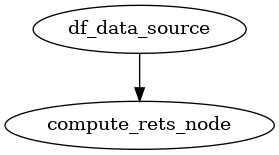

In [28]:
dtfcore.draw(dag)

The convenience function `dtfcore.draw_to_file()` may be used to save
the image of the graph of a ".png" file.

### Executing DAGs

DAGs are executed by specifying
- the node whose results are desired
- the mode of operation ("fit" or "predict")

The function used for execution is `run_leq_node()`. As the naming
suggests, all ancestor nodes of the result node specified are
executed (always respecting topological order).

Unless one deliberately introduces random effects in a DAG node,
DAG execution is deterministic and idempotent, i.e.,
running the same DAG in the same way on the same data
yields the same results.

In [29]:
# An example DAG execution.
dag_df_out = dag.run_leq_node("compute_rets_node", "fit")["df_out"]
_LOG.debug(hpandas.df_to_str(dag_df_out))

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'df_data_source'
DEBUG 
################################################################################
Executing method 'fit' for node topological_id=0 nid='df_data_source' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.004 s)
DEBUG Executing node 'compute_rets_node'
DEBUG 
################################################################################
Executing method 'fit' for node topological_id=1 nid='compute_rets_node' ...
################################################################################
DEBUG pred_nid=df_data_source, nid=compute_rets_node
DEBUG kwargs are {'df_in':                              open                      high                       low                     close                   volume            
asset_id                      101      201      301     101      201      301     101      201      301     101      201  

ret_0                        open                      high                       low                     close                   volume            
                                101       201       301     101      201      301     101      201      301     101      201      301     101      201      301    101   201   301
2023-01-03 09:35:00-05:00       NaN       NaN       NaN  999.56  1000.01   1000.0  999.56  1001.05  1001.65  998.96  1000.01   1000.0  998.96  1000.72  1001.65   1002   970   935
2023-01-03 09:40:00-05:00  0.000741  -0.00044 -0.000909  999.01  1000.51  1001.17  999.88  1001.02  1001.17  999.01  1000.28  1000.35   999.7  1000.28  1000.74   1015   985   948
2023-01-03 09:45:00-05:00  -0.00117   0.00065 -0.000869   999.4  1000.91  1000.74   999.4  1001.14  1000.93  998.53  1000.87   999.87  998.53  1000.93   999.87    961  1006   997
                                ...       ...       ...     ...      ...      ...     ...      ...      ...     ...      ...      ...     ...      ...      ...    ...   ...   ...
2023-01-03 11:20:00-05:00  0.000423 -0.000879   0.00025  992.35  1000.33  1000.24  992.49  1000.62  1000.67  992.12   999.97  1000.24  992.38   999.97  1000.55    956   975  1019
2023-01-03 11:25:00-05:00  0.000756   0.00143   0.00049   991.9   1000.5  1000.77  993.31  1001.58  1001.67   991.9   1000.5  1000.77  993.13   1001.4  1001.04   1011   972  1043
2023-01-03 11:30:00-05:00  0.000201  0.000389  0.000889  992.54  1000.82  1001.58   993.4  1002.38  1002.38  992.54  1000.82  1001.58  993.33  1001.79  1001.93   1008   997   913

DEBUG None


Note that one need not specify the sink node when executing a DAG.
Specifying execution up to an intermediate node or even source node
is useful for verifying the correctness of data transformations and
debugging potential issues or unexpected behavior.

In the following example, we specify the source node.

In [30]:
dag_source_df_out = dag.run_leq_node("df_data_source", "fit")["df_out"]
_LOG.debug(hpandas.df_to_str(dag_source_df_out))

run_leq_node:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG Executing node 'df_data_source'
DEBUG 
################################################################################
Executing method 'fit' for node topological_id=0 nid='df_data_source' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.004 s)


open                      high                       low                     close                   volume            
asset_id                      101      201      301     101      201      301     101      201      301     101      201      301    101   201   301
2023-01-03 09:35:00-05:00  999.56  1000.01   1000.0  999.56  1001.05  1001.65  998.96  1000.01   1000.0  998.96  1000.72  1001.65   1002   970   935
2023-01-03 09:40:00-05:00  999.01  1000.51  1001.17  999.88  1001.02  1001.17  999.01  1000.28  1000.35   999.7  1000.28  1000.74   1015   985   948
2023-01-03 09:45:00-05:00   999.4  1000.91  1000.74   999.4  1001.14  1000.93  998.53  1000.87   999.87  998.53  1000.93   999.87    961  1006   997
                              ...      ...      ...     ...      ...      ...     ...      ...      ...     ...      ...      ...    ...   ...   ...
2023-01-03 11:20:00-05:00  992.35  1000.33  1000.24  992.49  1000.62  1000.67  992.12   999.97  1000.24  992.38   999.97  1000.55    956   975  1019
2023-01-03 11:25:00-05:00   991.9   1000.5  1000.77  993.31  1001.58  1001.67   991.9   1000.5  1000.77  993.13   1001.4  1001.04   1011   972  1043
2023-01-03 11:30:00-05:00  992.54  1000.82  1001.58   993.4  1002.38  1002.38  992.54  1000.82  1001.58  993.33  1001.79  1001.93   1008   997   913

DEBUG None


### Interactive DAG construction in a notebook

In this section we introduce a feature of DAGs that can be particularly
useful in interactive notebook sessions.

A common workflow is to rapidly develop a prototype of a data transformation
step in a notebook, then wrap the transformation in a DAG node or break it
into a handful of steps, each with its own node.

This process often involves some level of experimentation. For example, one
may begin by wrapping a large transformation into a single node, only to
decide later to split it into multiple nodes. Alternatively, one may decide
to add a preprocessing step to the computational pipeline. In either case,
the update requires making a change to the DAG.

Changing the DAG can always be accomplished by re-instatiating the object
and repeating the necessary construction steps. However, sometimes it is
more convenient to alter the DAG in-place.

The most basic ways to alter the DAG in-place are to use the following methods:
- `add_node()`
- `connect()`
- `remove_node()`

We note that calling `remove_node()` removes all connections to or from the
node to be removed.

In the default DAG mode, `mode="strict"`, `add_node()` is not idempotent.
Calling it twice with the same node will result in an assertion.
If, however, the DAG is instantiated with `mode="loose"`, then `add_node()`
becomes idempotent in the sense that the DAG will be the same whether the
method is invoked one time or multiple times.

Beyond that behavior, invoking `add_node()` on a node that already belongs
to the DAG will
- Remove the node to be added
- Remove all of that node's successors and incident edges
- Re-add the node to the graph (but not incident edges or successors)

This behavior makes it easier to re-run DAG construction notebook cells
without requiring a complete re-instantiation and re-build. In order
to take advantages of this behavior, one must use the lower-level methods
`add_node()` and `connect()` rather than the convenience method `append_to_tail()`.

In the following, we demonstrate how to build a DAG with these methods
and show how the behavior is idempotent.

In [31]:
name = "my_dag"
# The default `mode` is "strict".
mode = "loose"
dag = dtfcore.DAG(name=name, mode=mode)
# Note that DAG objects can print information about their state.
display(dag)

DEBUG name='my_dag', mode='loose'
DEBUG save_node_io='', profile_execution=False, dst_dir=None


<dataflow.core.dag.DAG at 0xffff3a546370>:
  _nx_dag='DiGraph with 0 nodes and 0 edges' <networkx.classes.digraph.DiGraph>
  _name='my_dag' <str>
  _mode='loose' <str>
  _save_node_io='' <str>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[]
  edges=[]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [],
      "multigraph": false,
      "nodes": []
  }

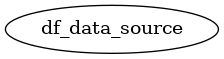

In [32]:
# Specify the data source node.
nid = "df_data_source"
df_data_source = dtfcore.DfDataSource(nid, market_data)
# Add the data source node to the DAG.
dag.add_node(df_data_source)
# Draw the DAG.
dtfcore.draw(dag)

WARNING Node `df_data_source` is already in DAG. Removing existing node, successors, and all incident edges of such nodes
WARNING Removing nid=df_data_source


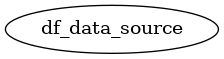

In [33]:
# Call `add_node()` a second time.
dag.add_node(df_data_source)
# Draw the DAG.
dtfcore.draw(dag)

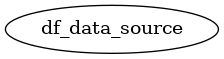

In [34]:
# Specify a return computation node.
nid = "compute_rets_node"
compute_rets_node = dtfcore.GroupedColDfToDfTransformer(
    nid,
    transformer_func=lambda x: x.pct_change(),
    in_col_groups=[("close",)],
    out_col_group=(),
    col_mapping={"close": "ret_0"},
)
# Draw the DAG.
dtfcore.draw(dag)

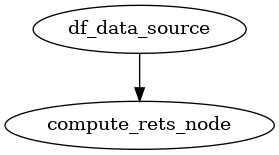

In [35]:
# Add the return computation node to the graph.
dag.add_node(compute_rets_node)
# Connect the data source node to the return computation node.
dag.connect("df_data_source", "compute_rets_node")
# Draw the DAG.
dtfcore.draw(dag)

WARNING Node `compute_rets_node` is already in DAG. Removing existing node, successors, and all incident edges of such nodes
WARNING Removing nid=compute_rets_node


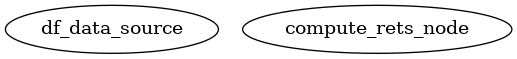

In [36]:
# Call `add_node()` a second time with `compute_rets_node`.
dag.add_node(compute_rets_node)
# Draw the DAG.
dtfcore.draw(dag)

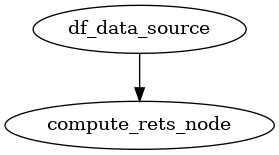

In [37]:
# Re-connect the data source node to the return computation node.
dag.connect("df_data_source", "compute_rets_node")
# Draw the DAG.
dtfcore.draw(dag)

# Cookbook Examples

## Resampling OHLCV bars

In this example, we resample OHLCV data, returning OHLCV columns as
well as TWAP and VWAP prices computed from the input "close" prices.

The output frequency of the data is specified with a string following
pandas' semantics, e.g,. "10T" would denote 10 minutes, and "1B" would
denote 1 business day.

The resampling example provided here is not the only way to implement
resampling. Any user-defined resampling procedure could be used instead.

In [38]:
# This controls the output data frequency.
resampling_rule = "30T"
# This is a configuration for the resampling node.
# - "in_col_groups" specifies the input columns to feed to the node
# - "out_col_group" is unused and should be set to an empty tuple
# - "transformer_kwargs" consists of arguments to be forward to `transformer_func`,
#   which in this case is `cofinanc.resample_bars()`. This may be replaced with any
#   user-defined function as desired.
# - "reindex_like_input" is `True` by default, but set to `False` here, because a
#   resampling operation in general changes the index
# - "join_output_with_input" is `True` by default (columns are appended), but set
#   to `False` here, since we wish to replace the input data with the resampled data
node_config = {
    "in_col_groups": [
        ("close",),
        ("high",),
        ("low",),
        ("open",),
        ("volume",),
    ],
    "out_col_group": (),
    "transformer_kwargs": {
        "rule": resampling_rule,
        "resampling_groups": [
            ({"close": "close"}, "last", {}),
            ({"high": "high"}, "max", {}),
            ({"low": "low"}, "min", {}),
            ({"open": "open"}, "first", {}),
            (
                {"volume": "volume"},
                "sum",
                {"min_count": 1},
            ),
            (
                {
                    "close": "twap",
                },
                "mean",
                {},
            ),
        ],
        "vwap_groups": [
            ("close", "volume", "vwap"),
        ],
    },
    "reindex_like_input": False,
    "join_output_with_input": False,
}
nid = "resample"
node = dtfcore.GroupedColDfToDfTransformer(
    nid,
    transformer_func=cofinanc.resample_bars,
    **node_config,
)

In [39]:
# Execute the node.
df_out = node.fit(market_data)["df_out"]
_LOG.debug(hpandas.df_to_str(df_out))

DEBUG out_col_names=['close', 'high', 'low', 'open', 'volume']
DEBUG keys=[101, 201, 301]
DEBUG col group roots=[()]
DEBUG Using symbol=`101` for reference index and columns


close                      high                       low                     open                          twap                           volume                    vwap                          
                              101      201      301     101      201      301     101     201      301     101      201      301         101          201          301    101   201   301         101          201          301
end_datetime                                                                                                                                                                                                                   
2023-01-03 10:00:00-05:00  996.76   998.18  1000.20  999.88  1001.58  1001.80  995.71  998.16   999.87  999.56  1000.01  1000.00  998.023333  1000.240000  1000.860000   5963  6005  5785  998.031670  1000.231680  1000.856254
2023-01-03 10:30:00-05:00  994.73   998.59  1003.47  997.18   999.37  1003.47  994.73  997.53   999.22  996.66   998.54  1000.53  996.251667   998.531667  1000.646667   5920  5971  6054  996.251743   998.528255  1000.637750
2023-01-03 11:00:00-05:00  991.12  1000.30  1001.73  994.34  1000.89  1003.79  990.78  998.41  1001.19  994.34   998.49  1003.55  991.920000   999.838333  1002.050000   6036  6106  6112  991.915986   999.843040  1002.050623
2023-01-03 11:30:00-05:00  993.33  1001.79  1001.93  993.40  1002.38  1002.38  990.89  999.97  1000.24  990.89  1001.11  1002.20  992.380000  1001.015000  1001.323333   6000  5865  6060  992.384385  1001.018280  1001.310224

DEBUG None
